<a href="https://colab.research.google.com/github/hungpham13/Vietnamese-HTR/blob/main/ScrabbleGAN_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ScrabbleGAN DEMO (TF 2.X)

more information: https://github.com/Nikolai10/scrabble-gan

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

## Download Project

In [1]:
# download project
!git clone -b dev https://github.com/Nikolai10/scrabble-gan.git

Cloning into 'scrabble-gan'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 69 (delta 26), reused 16 (delta 16), pack-reused 31
Unpacking objects: 100% (69/69), done.


## Download Dataset (For Demonstration Purpose Only)

In [2]:
! gdown https://drive.google.com/uc?id=1duoY9gBmx6quHNGWDlQGKIYO2ubsVZ-y

Downloading...
From: https://drive.google.com/uc?id=1duoY9gBmx6quHNGWDlQGKIYO2ubsVZ-y
To: /content/data.zip
100% 1.39G/1.39G [00:14<00:00, 93.5MB/s]


In [3]:
# external users: manually download https://drive.google.com/file/d/1duoY9gBmx6quHNGWDlQGKIYO2ubsVZ-y/view?usp=sharing
# place files as described in https://github.com/Nikolai10/scrabble-gan (Setup)
!mkdir -p /content/scrabble-gan/res/data/iamDB
!unzip -q /content/data.zip -d /content/scrabble-gan/res/

## Visualize some images

In [13]:
import glob
import json
import time
import random
import os
from pathlib import Path
import matplotlib.pyplot as plt

all_img = [path for path in Path('/content/scrabble-gan/res/data/iamDB/words').rglob('*.png')]
len(all_img)
with open("/content/scrabble-gan/res/data/iamDB/words.txt") as f:
    lines = f.readlines()
    lines = [l for l in lines if not l.startswith("#")]

Format of IAM database:
a01-000u-00-00 ok 154 1 408 768 27 51 AT A

- a01-000u-00-00  -> word id for line 00 in form a01-000u
- ok              -> result of word segmentation
    -                            ok: word was correctly
    -                            er: segmentation of word can be bad

-     154             -> graylevel to binarize the line containing this word
-     1               -> number of components for this word
-     408 768 27 51   -> bounding box around this word in x,y,w,h format
-     AT              -> the grammatical tag for this word, see the file tagset.txt for an explanation
-     A               -> the transcription for this word

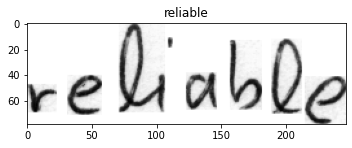

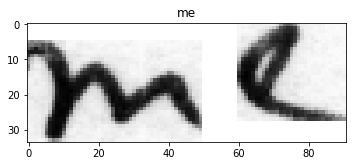

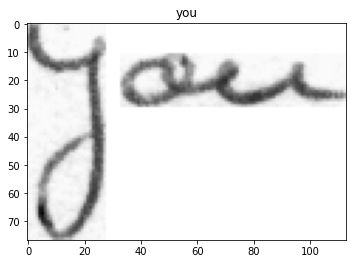

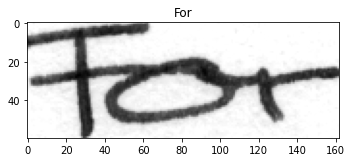

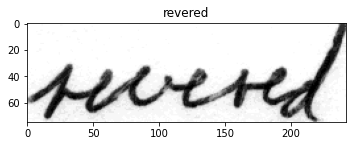

In [17]:
plt.rcParams["figure.figsize"] = [5.00, 5.50]
plt.rcParams["figure.autolayout"] = True
for _ in range(5):
    image_path = all_img[random.randrange(0,len(all_img))]
    im = plt.imread(image_path)
    image_name = os.path.basename(image_path).split('.')[0]
    label = [l.split()[-1] for l in lines if l.startswith(image_name)][0]
    fig, ax = plt.subplots()
    im = ax.imshow(im,cmap='gray')
    ax.set_title(label)
    plt.show()

## Import Libs

In [ ]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_6jldfi9
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_6jldfi9
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184155 sha256=fb9765b69ba86958e8e3f1520f242f26057b48596b9fea8136fec30038447350
  Stored in directory: /tmp/pip-ephem-wheel-cache-ic3klwn8/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
import sys
sys.path.extend(['/content/scrabble-gan'])

import os
import random

import gin
import numpy as np
import tensorflow as tf
# import tensorflow_docs.vis.embed as embed
import matplotlib.pyplot as plt

from src.bigacgan.arch_ops import spectral_norm
from src.bigacgan.data_utils import load_prepare_data, train, make_gif, load_random_word_list
from src.bigacgan.net_architecture import make_generator, make_discriminator, make_recognizer, make_gan
from src.bigacgan.net_loss import hinge, not_saturating

gin.external_configurable(hinge)
gin.external_configurable(not_saturating)
gin.external_configurable(spectral_norm)

from src.dinterface.dinterface import init_reading

## Init Config Params

In [ ]:
@gin.configurable
def setup_optimizer(g_lr, d_lr, r_lr, beta_1, beta_2, loss_fn, disc_iters):
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=g_lr, beta_1=beta_1, beta_2=beta_2)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=d_lr, beta_1=beta_1, beta_2=beta_2)
    recognizer_optimizer = tf.keras.optimizers.Adam(learning_rate=r_lr, beta_1=beta_1, beta_2=beta_2)
    return generator_optimizer, discriminator_optimizer, recognizer_optimizer, loss_fn, disc_iters


@gin.configurable('shared_specs')
def get_shared_specs(epochs, batch_size, latent_dim, embed_y, num_gen, kernel_reg, g_bw_attention, d_bw_attention):
    return epochs, batch_size, latent_dim, embed_y, num_gen, kernel_reg, g_bw_attention, d_bw_attention


@gin.configurable('io')
def setup_io(base_path, checkpoint_dir, gen_imgs_dir, model_dir, raw_dir, read_dir, input_dim, buf_size, n_classes,
             seq_len, char_vec, bucket_size):
    gen_path = base_path + gen_imgs_dir
    ckpt_path = base_path + checkpoint_dir
    m_path = base_path + model_dir
    raw_dir = base_path + raw_dir
    read_dir = base_path + read_dir
    return input_dim, buf_size, n_classes, seq_len, bucket_size, ckpt_path, gen_path, m_path, raw_dir, read_dir, char_vec

In [ ]:
# init params
gin.parse_config_file('/content/scrabble-gan/src/scrabble_gan.gin')
epochs, batch_size, latent_dim, embed_y, num_gen, kernel_reg, g_bw_attention, d_bw_attention = get_shared_specs()
in_dim, buf_size, n_classes, seq_len, bucket_size, ckpt_path, gen_path, m_path, raw_dir, read_dir, char_vec = setup_io()

## Load and Preprocess Dataset

In [ ]:
# convert IAM Handwriting dataset (words) to GAN format
if not os.path.exists(read_dir):
  print('converting iamDB-Dataset to GAN format...')
  init_reading(raw_dir, read_dir, in_dim, bucket_size)

# load random words into memory (used for word generation by G)
random_words = load_random_word_list(read_dir, bucket_size, char_vec)

# load and preprocess dataset (python generator)
train_dataset = load_prepare_data(in_dim, batch_size, read_dir, char_vec, bucket_size)

## Build Composite Model

In [ ]:
# init generator, discriminator and recognizer
generator = make_generator(latent_dim, in_dim, embed_y, gen_path, kernel_reg, g_bw_attention, n_classes)
discriminator = make_discriminator(gen_path, in_dim, kernel_reg, d_bw_attention)
recognizer = make_recognizer(in_dim, seq_len, n_classes + 1, gen_path)

# build composite model (update G through composite model)
gan = make_gan(generator, discriminator, recognizer, gen_path)

# init optimizer for both generator, discriminator and recognizer
generator_optimizer, discriminator_optimizer, recognizer_optimizer, loss_fn, disc_iters = setup_optimizer()

input shape
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 SpatialEmbedding (SpatialEmbed  (None, None, 32, 81  13631488   ['input_2[0][0]']                
 ding)                          92)                                                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 32),         0           ['input_1[0][0]']

## Define Optimizers + Checkpoint-Saver


In [ ]:
# purpose: save and restore models
checkpoint_prefix = os.path.join(ckpt_path, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     recognizer_optimizer=recognizer_optimizer,
                                     generator=generator,
                                     discriminator=discriminator,
                                     recognizer=recognizer)


## Start Training

**note:** If you use the [free Colab version](https://colab.research.google.com/signup), you should first reduce the number of epochs (e.g. epochs=5) to not exceed the 12h time limit.  

In [ ]:
# reuse this seed + labels overtime to visualize progress in the animated GIF
seed = tf.random.normal([num_gen, latent_dim])
random_bucket_idx = random.randint(4, bucket_size - 1)
labels = np.array([random.choice(random_words[random_bucket_idx]) for _ in range(num_gen)], np.int32)

Streaming output truncated to the last 5000 lines.
>1, 26/2512, d=19.070, d_real=19.070, d_fake=0.000, g_trad=24.026, r_loss_fake=11.800, g_loss=35.825, r=10.110
>1, 27/2512, d=2.642, d_real=0.015, d_fake=2.627, g_trad=0.102, r_loss_fake=19.581, g_loss=19.683, r=7.531
>1, 28/2512, d=1.654, d_real=1.142, d_fake=0.512, g_trad=0.921, r_loss_fake=25.517, g_loss=26.438, r=17.918
>1, 29/2512, d=1.306, d_real=0.488, d_fake=0.818, g_trad=0.583, r_loss_fake=39.672, g_loss=40.256, r=22.897
>1, 30/2512, d=1.269, d_real=0.320, d_fake=0.949, g_trad=0.492, r_loss_fake=14.797, g_loss=15.289, r=20.898
>1, 31/2512, d=1.246, d_real=0.428, d_fake=0.817, g_trad=0.583, r_loss_fake=14.895, g_loss=15.479, r=27.729
>1, 32/2512, d=1.203, d_real=0.158, d_fake=1.045, g_trad=0.439, r_loss_fake=10.162, g_loss=10.602, r=22.786
>1, 33/2512, d=1.314, d_real=0.629, d_fake=0.685, g_trad=0.701, r_loss_fake=41.322, g_loss=42.023, r=32.832
>1, 34/2512, d=1.162, d_real=0.229, d_fake=0.933, g_trad=0.501, r_loss_fake=49.284,

/content/scrabble-gan/src/bigacgan/data_utils.py:274: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4, 4, i + 1)


Streaming output truncated to the last 5000 lines.
>14, 26/2512, d=0.165, d_real=0.162, d_fake=0.003, g_trad=11.085, r_loss_fake=2.502, g_loss=13.587, r=0.059
>14, 27/2512, d=0.080, d_real=0.007, d_fake=0.072, g_trad=5.648, r_loss_fake=1.407, g_loss=7.055, r=0.281
>14, 28/2512, d=0.054, d_real=0.003, d_fake=0.051, g_trad=7.726, r_loss_fake=1.111, g_loss=8.838, r=0.239
>14, 29/2512, d=0.020, d_real=0.004, d_fake=0.016, g_trad=9.497, r_loss_fake=2.557, g_loss=12.055, r=0.037
>14, 30/2512, d=0.078, d_real=0.060, d_fake=0.017, g_trad=9.231, r_loss_fake=2.299, g_loss=11.530, r=0.143
>14, 31/2512, d=0.034, d_real=0.027, d_fake=0.007, g_trad=9.472, r_loss_fake=3.124, g_loss=12.596, r=0.343
>14, 32/2512, d=0.003, d_real=0.000, d_fake=0.003, g_trad=8.740, r_loss_fake=2.518, g_loss=11.257, r=0.604
>14, 33/2512, d=0.008, d_real=0.003, d_fake=0.004, g_trad=9.900, r_loss_fake=2.091, g_loss=11.991, r=0.386
>14, 34/2512, d=0.052, d_real=0.000, d_fake=0.052, g_trad=6.180, r_loss_fake=2.473, g_loss=8.6

Time for epoch 15 is 1274.1641314029694 sec


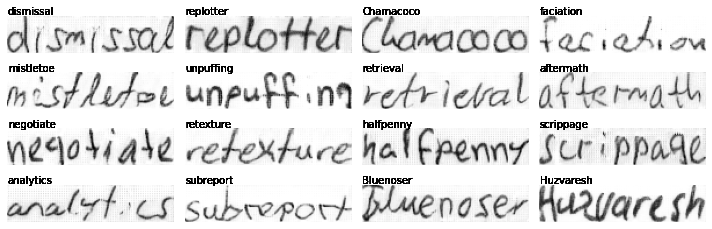

In [ ]:
# start training
train(train_dataset, generator, discriminator, recognizer, gan, checkpoint, checkpoint_prefix, generator_optimizer,
          discriminator_optimizer, recognizer_optimizer, [seed, labels], buf_size, batch_size, epochs, m_path,
          latent_dim, gen_path, loss_fn, disc_iters, random_words, bucket_size, char_vec)

In [ ]:
# use imageio to create an animated gif using the images saved during training.
make_gif(gen_path)
embed.embed_file(gen_path + 'biggan.gif')

## Run Inference On Your Data

In [ ]:
path_to_saved_model = '/content/scrabble-gan/res/out/big_ac_gan/model/generator_' + str(epochs)

# number of samples to generate
n_samples = 10
# your sample string
sample_string = 'machinelearning'

# load trained model
imported_model = tf.saved_model.load(path_to_saved_model)

# inference loop
for idx in range(1):
  fake_labels = []
  words = [sample_string] * 10
  noise = tf.random.normal([n_samples, latent_dim])
  
  # encode words
  for word in words:
    fake_labels.append([char_vec.index(char) for char in word])
  fake_labels = np.array(fake_labels, np.int32)

  # run inference process
  predictions = imported_model([noise, fake_labels], training=False)
  # transform values into range [0, 1]
  predictions = (predictions + 1) / 2.0

  # plot results
  for i in range(predictions.shape[0]):
    plt.subplot(10, 1, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    # plt.text(0, -1, "".join([char_vec[label] for label in fake_labels[i]]))
    plt.axis('off')
    plt.show()